# Autogluon Tutorial

In [66]:
import pandas as pd
import autogluon.timeseries
from plotnine import *
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.models import PatchTSTModel, TemporalFusionTransformerModel

In [67]:
combined_data = pd.read_parquet("/Users/jakegwinn/Documents/umich/Y5S2/urps/urps_2025/combined_data/combined_data.parquet")

In [68]:
combined_data[combined_data["USFLUX"] == combined_data.iloc[1]["USFLUX"]]

,T_REC,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,MEANJZH,...,NPIX,SIZE,AREA,NACR,SIZE_ACR,AREA_ACR,flux,max_flux_next_24h,max_flare_class_next_24h,max_peak_intensity_next_24h
1,2010-05-01 00:12:00+00:00,1.439345e+21,32.159885,137.783195,137.832428,59.383249,0.528793,2.065877e+12,0.001307,-0.000677,...,21385.121136,1908.233367,1124.079598,1636.651525,146.041405,86.29848,6.331756e-08,0.000008,C,0.000008


In [69]:
cd = combined_data.drop(0)
cd1 = cd[cd["USFLUX"].notna()].copy()
cd1["T_REC"] = pd.to_datetime(cd1["T_REC"], errors="coerce").dt.tz_localize(None)
cd1["T_REC"].dtype
cd1["USFLUX"].dtype
print(cd1["USFLUX"].dtype)  # Confirm it outputs int64 (or int32)
print(cd1["USFLUX"].isna().sum())  # Ensure this is 0
# cd1["USFLUX"] = cd1["USFLUX"].astype(int)

for col in cd1.columns:
    unique_values = cd1[col].nunique()
    total_values = len(cd1[col])
    print(f"Column '{col}' has {unique_values} unique values out of {total_values} total entries.")
    
cd1["id"] = 0

def clean_data(df):
    # Drop columns: 'max_flux_next_24h', 'max_flare_class_next_24h', 'max_peak_intensity_next_24h'
    df = df.drop(columns=['max_flux_next_24h', 'max_flare_class_next_24h', 'max_peak_intensity_next_24h'])
    df["target"] = df["USFLUX"]
    return df

# Loaded variable 'df' from URI: /Users/jakegwinn/Documents/umich/Y5S2/urps/urps_2025/combined_data/combined_data.parquet

cd1_clean = clean_data(cd1.copy())
cd1_clean.ffill()
cd1_clean.head()

float64
0
Column 'T_REC' has 477478 unique values out of 477478 total entries.
Column 'USFLUX' has 477370 unique values out of 477478 total entries.
Column 'MEANGAM' has 450864 unique values out of 477478 total entries.
Column 'MEANGBT' has 465841 unique values out of 477478 total entries.
Column 'MEANGBZ' has 465915 unique values out of 477478 total entries.
Column 'MEANGBH' has 460952 unique values out of 477478 total entries.
Column 'MEANJZD' has 477461 unique values out of 477478 total entries.
Column 'TOTUSJZ' has 477372 unique values out of 477478 total entries.
Column 'MEANALP' has 477283 unique values out of 477478 total entries.
Column 'MEANJZH' has 476897 unique values out of 477478 total entries.
Column 'TOTUSJH' has 473506 unique values out of 477478 total entries.
Column 'ABSNJZH' has 453383 unique values out of 477478 total entries.
Column 'SAVNCPP' has 477384 unique values out of 477478 total entries.
Column 'MEANPOT' has 477054 unique values out of 477478 total entries.

,T_REC,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,MEANJZH,...,SHRGT45,NPIX,SIZE,AREA,NACR,SIZE_ACR,AREA_ACR,flux,id,target
1,2010-05-01 00:12:00,1.439345e+21,32.159885,137.783195,137.832428,59.383249,0.528793,2.065877e+12,0.001307,-0.000677,...,7.166919,21385.121136,1908.233367,1124.079598,1636.651525,146.041405,86.298480,6.331756e-08,0,1.439345e+21
2,2010-05-01 00:24:00,1.488903e+21,32.006564,138.032814,137.932202,58.588763,0.355526,2.096785e+12,0.001291,-0.000588,...,6.112795,22631.582458,2019.510773,1188.056979,1754.132156,156.528544,92.311965,6.583243e-08,0,1.488903e+21
3,2010-05-01 00:36:00,1.495132e+21,32.489844,136.413847,136.048735,59.049505,0.317466,2.190448e+12,-0.001002,-0.001128,...,7.290995,23156.134658,2066.389478,1214.339188,1786.976723,159.464861,93.905701,7.199385e-08,0,1.495132e+21
4,2010-05-01 00:48:00,1.566065e+21,31.843583,136.656334,136.326496,58.237536,0.342064,2.305668e+12,-0.000914,-0.000872,...,6.565928,24186.736691,2158.422429,1267.802766,1847.651398,164.884269,97.054212,6.824671e-08,0,1.566065e+21
5,2010-05-01 01:00:00,1.581636e+21,32.029743,136.771497,136.505656,58.079512,0.160927,2.233088e+12,-0.000352,-0.001005,...,6.317723,24679.478496,2202.451682,1292.445468,1889.395343,168.613857,99.122971,6.633540e-08,0,1.581636e+21


In [70]:
tdf = autogluon.timeseries.TimeSeriesDataFrame(cd1_clean, id_column="id", timestamp_column="T_REC")

In [71]:
tdf

USFLUX    MEANGAM     MEANGBT     MEANGBZ  \
item_id timestamp                                                              
0       2010-05-01 00:12:00  1.439345e+21  32.159885  137.783195  137.832428   
        2010-05-01 00:24:00  1.488903e+21  32.006564  138.032814  137.932202   
        2010-05-01 00:36:00  1.495132e+21  32.489844  136.413847  136.048735   
        2010-05-01 00:48:00  1.566065e+21  31.843583  136.656334  136.326496   
        2010-05-01 01:00:00  1.581636e+21  32.029743  136.771497  136.505656   
...                                   ...        ...         ...         ...   
        2024-07-20 22:36:00  2.720302e+22  37.845543   90.727577   92.985876   
        2024-07-20 22:48:00  2.702650e+22  37.730233   90.997074   93.989457   
        2024-07-20 23:00:00  2.720881e+22  37.915577   89.712444   92.070134   
        2024-07-20 23:12:00  2.679498e+22  37.865517   90.082306   92.792197   
        2024-07-20 23:24:00  2.663576e+22  37.858723   90.155343   92.828990   

                               MEANGBH   MEANJZD       TOTUSJZ   MEANALP  \
item_id timestamp                                                          
0       2010-05-01 00:12:00  59.383249  0.528793  2.065877e+12  0.001307   
        2010-05-01 00:24:00  58.588763  0.355526  2.096785e+12  0.001291   
        2010-05-01 00:36:00  59.049505  0.317466  2.190448e+12 -0.001002   
        2010-05-01 00:48:00  58.237536  0.342064  2.305668e+12 -0.000914   
        2010-05-01 01:00:00  58.079512  0.160927  2.233088e+12 -0.000352   
...                                ...       ...           ...       ...   
        2024-07-20 22:36:00  47.340764  0.031313  3.524192e+13 -0.006777   
        2024-07-20 22:48:00  47.374821  0.029481  3.548465e+13 -0.007093   
        2024-07-20 23:00:00  46.754862  0.035847  3.579820e+13 -0.007360   
        2024-07-20 23:12:00  47.017530  0.051555  3.558272e+13 -0.007589   
        2024-07-20 23:24:00  46.845258  0.040622  3.564839e+13 -0.007620   

                              MEANJZH      TOTUSJH  ...    MEANSHR    SHRGT45  \
item_id timestamp                                   ...                         
0       2010-05-01 00:12:00 -0.000677   103.413242  ...  24.980931   7.166919   
        2010-05-01 00:24:00 -0.000588   104.334118  ...  24.549219   6.112795   
        2010-05-01 00:36:00 -0.001128   105.544694  ...  25.103040   7.290995   
        2010-05-01 00:48:00 -0.000872   110.540304  ...  24.838363   6.565928   
        2010-05-01 01:00:00 -0.001005   107.304800  ...  24.577836   6.317723   
...                               ...          ...  ...        ...        ...   
        2024-07-20 22:36:00 -0.002036  1717.244811  ...  30.584566  20.261831   
        2024-07-20 22:48:00 -0.002178  1749.711650  ...  30.399797  20.088999   
        2024-07-20 23:00:00 -0.002208  1737.517493  ...  30.465852  20.302462   
        2024-07-20 23:12:00 -0.002365  1741.393675  ...  30.396937  20.283340   
        2024-07-20 23:24:00 -0.002385  1740.876410  ...  30.391622  20.302913   

                                      NPIX          SIZE         AREA  \
item_id timestamp                                                       
0       2010-05-01 00:12:00   21385.121136   1908.233367  1124.079598   
        2010-05-01 00:24:00   22631.582458   2019.510773  1188.056979   
        2010-05-01 00:36:00   23156.134658   2066.389478  1214.339188   
        2010-05-01 00:48:00   24186.736691   2158.422429  1267.802766   
        2010-05-01 01:00:00   24679.478496   2202.451682  1292.445468   
...                                    ...           ...          ...   
        2024-07-20 22:36:00  117130.822362  10614.740841  7730.637581   
        2024-07-20 22:48:00  117454.012434  10644.251650  7730.099298   
        2024-07-20 23:00:00  117383.036542  10638.009174  7722.747066   
        2024-07-20 23:12:00  117991.475358  10693.435158  7733.647927   
        2024-07-20 23:24:00  118618.610534  10750.524466  7742.059875   

 

In [72]:
tdf
tdf = tdf.iloc[:11000,:]
prediction_length = 1000 

train_data, test_data = tdf.train_test_split(prediction_length)

print(len(train_data), len(test_data))

10000 11000


In [73]:
predictor = TimeSeriesPredictor(
    freq = "12T",
    prediction_length= 1000, # 1000
    #target= "target",
    #known_covariates_names= known_covariates_names,
).fit(
    train_data,
    hyperparameters={
        "PatchTST": [
            # Zero-shot model WITHOUT covariates
            {
                #"model_path": "bolt_small", # only the historical values of unit_sales
                "target_scaler": "standard",
                #"ag_args": {"name_suffix": "ZeroShot"},
                #"nhead": 5,
            }#,

            # {
            #     "model_path": "bolt_small",
            #     "covariate_regressor": "CAT",
            #     "target_scaler": "standard",
            #     "ag_args": {"name_suffix": "WithRegressor"},
            #     #"nhead": 8,
            # }

        ]#,

        # "TemporalFusionTransformerModel": [
        #     # Zero-shot model WITHOUT covariates
        #     {
        #         "model_path": "bolt_small", # only the historical values of unit_sales
        #         "ag_args": {"name_suffix": "ZeroShot"},
        #         #"hidden_dim": 64,
        #     },

        #     {
        #         "model_path": "bolt_small",
        #         "covariate_regressor": "CAT",
        #         "target_scaler": "standard",
        #         "ag_args": {"name_suffix": "WithRegressor"},
        #         #"hidden_dim": 124,
        #     }

        # ]
    },
    enable_ensemble= False, #False, 
    time_limit= 120,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250128_160803"
/Users/jakegwinn/Documents/umich/Y5S2/urps/urps_2025/autogluon_env/lib/python3.11/site-packages/autogluon/timeseries/predictor.py:197: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
Frequency '12T' stored as '12min'
Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to '/Users/jakegwinn/Documents/umich/Y5S2/urps/urps_2025/notebooks/jake_notebooks/AutogluonModels/ag-20250128_160803'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.6.0: Mon Jul 29 21:13:04 PDT 2024; root:xnu-10063.141.2~1/RELEASE_ARM64_T6020
CPU Count:          12
GPU Count:          0
Memory Avail:       25.30 GB / 64.00 GB (39.5%)
Disk Space Avail:   1038.81 GB / 1858.19 GB (55.9%)

Fitting with arguments:
{'ena

In [74]:
predictor.leaderboard(test_data)

data with frequency 'None' has been resampled to frequency '12min'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,PatchTST,-0.339115,-0.416487,0.094291,0.11162,109.024938,1


data with frequency 'None' has been resampled to frequency '12min'.
Model not specified in predict, will default to the model with the best validation score: PatchTST
data with frequency 'None' has been resampled to frequency '12min'.


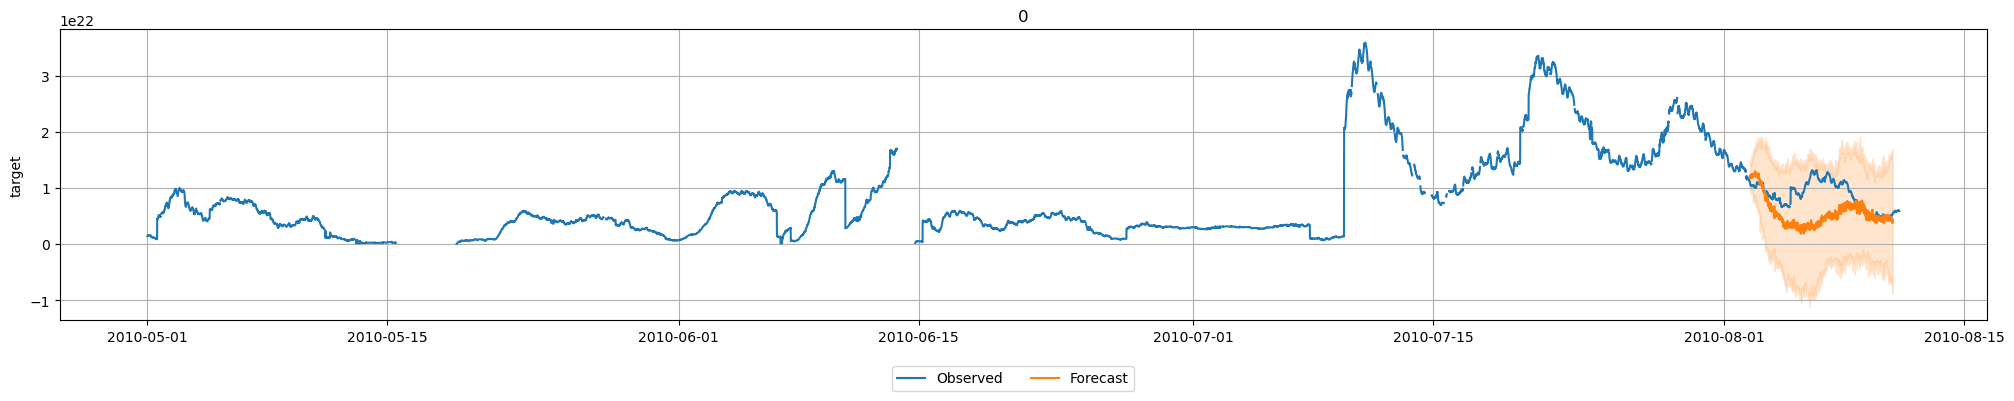

In [75]:
predictor.plot(
    test_data, 
    predictor.predict(train_data),
    quantile_levels=[0.1,0.9]
)

In [ ]:
def ComputeCoverage(data: pd.Series, input_window: int, stride: int, predictor: TimeSeriesPredictor, prediction_length: int):
    start_idxs = list(range(0, len(data)-input_window, stride))
    end_idxs = start_idxs + input_window - 1
    
    results = {}
    
    for(start_idx, end_idx in zip(start_idxs, end_idxs)):
        output = predictor.predict(data.iloc[start_idx:end_idx+1,]) # grab predictor and quantiles
        output["observation"] = data.iloc[(end_idx + 1): (end_idx + prediction_length+1)]
        # append to results
        